Eileen Zhang 2020/08/15

In [1]:
import tensorflow as tf

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = train_images/127 - 1 # 标准化到 [-1, 1]

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
def G_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 注意：batch size 没有限制

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

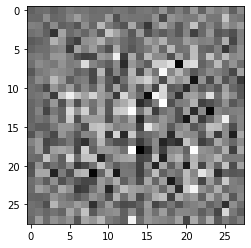

In [9]:
generator = G_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [10]:
def D_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = D_model()
pred = discriminator(generated_image)
print (pred)

tf.Tensor([[0.00021612]], shape=(1, 1), dtype=float32)


In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def d_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def g_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
g_opt = tf.keras.optimizers.Adam(1e-4)
d_opt = tf.keras.optimizers.Adam(1e-4)

In [16]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = g_loss(fake_output)
        disc_loss = d_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss,disc_loss

In [18]:
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [19]:
def train(dataset, epochs):
    gen_loss = ''
    disc_loss = ''
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
    if (epoch + 1) % 15 == 0:
        generate_images(generator, epochs,seed)
    print ('Time for epoch {} is {} sec, gen_loss : {}, disc_loss : {}'.format(epoch + 1, time.time()-start, gen_loss, disc_loss))

  # 查看最后一个 epoch 生成图片
  generate_images(generator, epochs,seed)

Time for epoch 1 is 8.170637845993042 sec, gen_loss : 0.8303192257881165, disc_loss : 1.2017755508422852
Time for epoch 2 is 5.8724586963653564 sec, gen_loss : 0.648442804813385, disc_loss : 1.7145733833312988
Time for epoch 3 is 5.808771848678589 sec, gen_loss : 0.8424546718597412, disc_loss : 1.1920106410980225
Time for epoch 4 is 5.800020456314087 sec, gen_loss : 0.7818232774734497, disc_loss : 1.3933581113815308
Time for epoch 5 is 5.8248677253723145 sec, gen_loss : 0.9375934600830078, disc_loss : 0.9862985610961914
Time for epoch 6 is 5.799464464187622 sec, gen_loss : 0.8076921105384827, disc_loss : 1.440873146057129
Time for epoch 7 is 5.801607847213745 sec, gen_loss : 0.8598051071166992, disc_loss : 1.1711649894714355
Time for epoch 8 is 5.799301862716675 sec, gen_loss : 0.8042010068893433, disc_loss : 1.3856594562530518
Time for epoch 9 is 5.803469896316528 sec, gen_loss : 0.8507705926895142, disc_loss : 1.1513887643814087
Time for epoch 10 is 5.800295114517212 sec, gen_loss : 

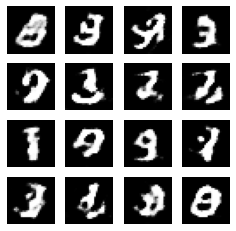

Time for epoch 15 is 6.195715427398682 sec, gen_loss : 1.1578692197799683, disc_loss : 0.9300739765167236
Time for epoch 16 is 5.81226110458374 sec, gen_loss : 1.2244595289230347, disc_loss : 0.9742194414138794
Time for epoch 17 is 5.814329385757446 sec, gen_loss : 1.2883387804031372, disc_loss : 1.1042925119400024
Time for epoch 18 is 5.805652141571045 sec, gen_loss : 1.1871392726898193, disc_loss : 1.0743775367736816
Time for epoch 19 is 5.820755481719971 sec, gen_loss : 1.1946741342544556, disc_loss : 1.1096572875976562
Time for epoch 20 is 5.803954601287842 sec, gen_loss : 1.4025846719741821, disc_loss : 0.8969541788101196
Time for epoch 21 is 5.808747291564941 sec, gen_loss : 1.2989693880081177, disc_loss : 0.876782238483429
Time for epoch 22 is 5.799371004104614 sec, gen_loss : 1.0860999822616577, disc_loss : 1.195888638496399
Time for epoch 23 is 5.805386543273926 sec, gen_loss : 1.4041650295257568, disc_loss : 0.9100723266601562
Time for epoch 24 is 5.812247037887573 sec, gen_l

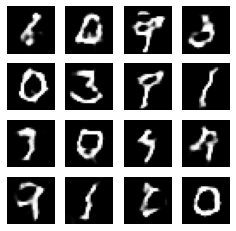

Time for epoch 30 is 6.280400514602661 sec, gen_loss : 1.2042973041534424, disc_loss : 1.0640301704406738
Time for epoch 31 is 5.808859586715698 sec, gen_loss : 1.1682466268539429, disc_loss : 1.0554232597351074
Time for epoch 32 is 5.804155111312866 sec, gen_loss : 1.0893445014953613, disc_loss : 1.1506187915802002
Time for epoch 33 is 5.80506157875061 sec, gen_loss : 1.0016999244689941, disc_loss : 1.2034165859222412
Time for epoch 34 is 5.811884880065918 sec, gen_loss : 0.9661475419998169, disc_loss : 1.2960014343261719
Time for epoch 35 is 5.809195518493652 sec, gen_loss : 1.051470398902893, disc_loss : 1.0780792236328125
Time for epoch 36 is 5.826871395111084 sec, gen_loss : 1.0363187789916992, disc_loss : 1.0934782028198242
Time for epoch 37 is 5.799903392791748 sec, gen_loss : 0.990561306476593, disc_loss : 1.1501429080963135
Time for epoch 38 is 5.820253372192383 sec, gen_loss : 1.0130767822265625, disc_loss : 1.202306866645813
Time for epoch 39 is 5.802791595458984 sec, gen_lo

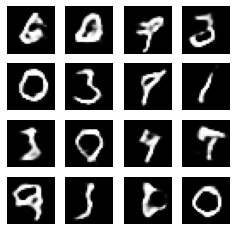

Time for epoch 45 is 6.187748193740845 sec, gen_loss : 1.037580966949463, disc_loss : 1.1028316020965576
Time for epoch 46 is 5.80554461479187 sec, gen_loss : 1.0011645555496216, disc_loss : 1.0946624279022217
Time for epoch 47 is 5.798712730407715 sec, gen_loss : 1.2512149810791016, disc_loss : 0.9345060586929321
Time for epoch 48 is 5.807108402252197 sec, gen_loss : 1.0637097358703613, disc_loss : 0.9820480346679688
Time for epoch 49 is 5.800041198730469 sec, gen_loss : 0.9436349272727966, disc_loss : 1.2690858840942383
Time for epoch 50 is 5.804527521133423 sec, gen_loss : 0.8935983777046204, disc_loss : 1.257853388786316


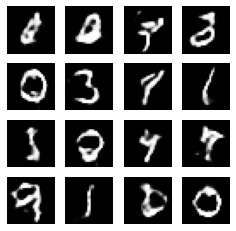

CPU times: user 1min 42s, sys: 15.3 s, total: 1min 57s
Wall time: 4min 55s


In [20]:
%%time
train(train_dataset, 50)